Students: <b>Jonas WACKER</b> & <b>Sofiene JERBI</b><br>
Group: <b>user4</b>

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work ?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.subtract(p1,p2)**2))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

## Alternative distance measure: cosine similarity

We would also like to employ another distance measure: the cosine similarity and see how it impacts the clustering result.

In [2]:
from scipy import spatial
# calculate inverse cos-similarity between two d-dimensional points
def l1_distance(p1, p2):
    return np.sum(np.absolute(np.subtract(p1,p2)))
    #return (1 - spatial.distance.cosine(p1, p2))

<div class="alert alert-warning">

The evaluation of the L1-distance will be carried out on the "blob" sample used below.

</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [3]:
def find_closest_centroid(datapoint, centroids, dist='l2'):
    # find the index of the closest centroid of the given data point.
    if dist == 'l2':
        distances = [euclidean_distance(datapoint, x) for x in centroids]
    else:
        distances = [l1_distance(datapoint, x) for x in centroids]
    return(np.argmin(distances))

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [4]:
np.random.seed(123)

# randomize initial centroids
def randomize_centroids(data, k):
    #centroids = np.random.rand(k,len(data[0]))
    # select random representative datapoints
    random_ind = np.random.randint(0,data.shape[0],k)
    centroids = data[random_ind]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

## Alternative initialisation: k-means++

In the following, we implement the k-means++ seeding for the initial centroids using the approach described by David Arthur and Sergei Vassilvitskii: http://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf<br />
The initialisation technique is known to improve speed as well as accuracy of the k-Means clustering.<br />
The centroids are sampled from a probability distribution based on the squared distances of the datapoints to each centroid.

In [5]:
import numpy as np
import random

# get a list of squared distances for each datapoint to the resp. closest centroid.
def _dist_from_centers(centroids, data):
    D2 = np.array([np.min([np.linalg.norm(x-c)**2 for c in centroids]) for x in data])
    return D2

# sample the next centroid using the list of squared distances obtained above.
def _choose_next_center(data, D2):
    probs = D2/D2.sum()
    cumprobs = probs.cumsum()
    r = random.random()
    ind = np.where(cumprobs >= r)[0][0]
    return(data[ind])

# actual initialisation method
def init_centroids_kpp(data, k):
    random_ind = np.random.randint(0,data.shape[0],1)
    centroids = data[random_ind]
    while len(centroids) < k:
        D2 = _dist_from_centers(centroids, data)
        centroids = np.append(centroids, [_choose_next_center(data, D2)], axis=0)
    return centroids

assert(len(
    init_centroids_kpp(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop creteria of the algorithm.

</div>

In [6]:
# MAX_ITERATIONS = 10000
MAX_ITERATIONS = 200

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0, dist='l2'):
    # if it reaches an iteration budget
    if num_iterations >= MAX_ITERATIONS:
        return(True)
    # check if the centroids don't move (or very slightly)
    if dist == 'l2':
        stop = [euclidean_distance(centroids[i], old_centroids[i])<=threshold for i in range(len(centroids))]
    else:
        stop = [l1_distance(centroids[i], old_centroids[i])<=threshold for i in range(len(centroids))]
    return(all(stop))

assert(check_converge([ [1,1,2], [1,2,1], [3,1,2] ],[ [2,1,2], [1,2,1], [3,1,2] ],MAX_ITERATIONS-1)==False)
assert(check_converge([ [1,1,2], [1,2,1], [3,1,2] ],[ [2,1,2], [1,2,1], [3,1,2] ],MAX_ITERATIONS)==True)
assert(check_converge([ [2,1,2], [1,2,1], [3,1,2] ],[ [2,1,2], [1,2,1], [3,1,2] ],MAX_ITERATIONS-1)==True)

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [7]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for i in range(len(centroids)):
        centroids[i]=np.mean(cluster[i], axis=0)
    return centroids

assert(np.array_equal(update_centroids([[5,5,5],[6,6,6]],[[[1,1,1], [2,2,2], [3,3,3]],[[1,1,1], [2,1,2], [3,1,3]]]),[[2,2,2],[2,1,2]]))

Actually we have two possibilities for the new centroids:
    - either take points in the dataspace (barycentres of each cluster) that are not necesseraly part of the dataset (most of the time not) as we did above
    - or take the closest point in the dataset to the barycentre described above as we are going to do below

In [8]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids_2(centroids, cluster):
    for i in range(len(centroids)):
        barycentre=np.mean(cluster[i], axis=0)
        centroids[i]=cluster[i][np.argmin([euclidean_distance(point,barycentre) for point in cluster[i]])]
    return centroids

assert(np.array_equal(update_centroids_2([[5,5,5],[6,6,6]],[[[1,1,1], [2,2,2], [4,4,4]],[[1,1,1], [2,1,2], [3,1,3]]]),[[2,2,2],[2,1,2]]))

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm scheleton below, with the functions you wrote above.

</div>

In [9]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None, threshold=0, dist='l2'):
    
    # randomize the centroids if they are not given
    if not centroids:
        #centroids = randomize_centroids(data, k)
        centroids = init_centroids_kpp(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids, dist=dist)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx]+=[datapoint]
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold, dist=dist):
            return(centroids)
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

In [76]:
from sklearn import datasets, cluster

In [77]:
X, y = datasets.make_moons(2000, noise=0.2)
np.max(y_iris)

2

In [78]:

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
centers_iris = kmeans(X_iris, k=np.max(y_iris)+1)


In [79]:
np.max(y_iris)+1

3

In [80]:
print(centers_iris)

[[ 6.72195122  2.99756098  5.69512195  2.07560976]
 [ 5.23333333  3.11234568  2.43580247  0.62592593]
 [ 6.32142857  2.96785714  4.75        1.57142857]]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


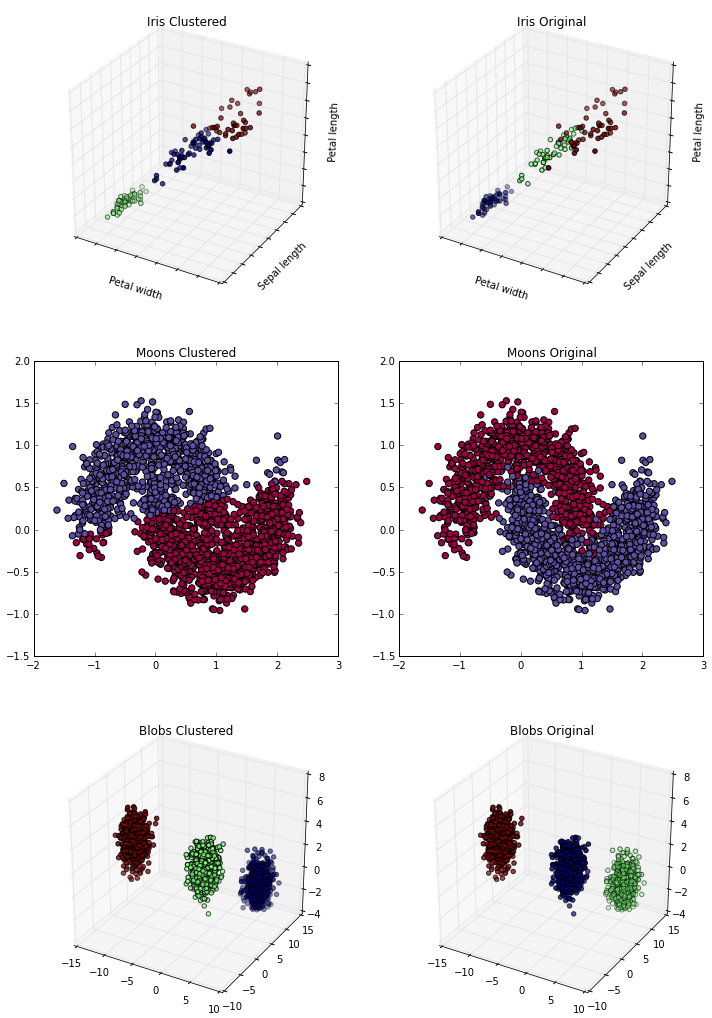

In [35]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 18))

# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers_iris = kmeans(X_iris, k=np.max(y_iris)+1)
labels_iris = [find_closest_centroid(p, centers_iris) for p in X_iris]

#plot the clusters in color
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels_iris)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Iris Clustered')

ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=y_iris)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Iris Original')

# moon
np.random.seed(0)
X_moon, y_moon = datasets.make_moons(2000, noise=0.2)

centers_moon = kmeans(X_moon, k=np.max(y_moon)+1)
labels_moon = [find_closest_centroid(p, centers_moon) for p in X_moon]

ax = fig.add_subplot(3, 2, 3)
ax.scatter(X_moon[:,0], X_moon[:,1], s=40, c=labels_moon, cmap=plt.cm.Spectral)
ax.set_title('Moons Clustered')
ax = fig.add_subplot(3, 2, 4)
ax.scatter(X_moon[:,0], X_moon[:,1], s=40, c=y_moon, cmap=plt.cm.Spectral)
ax.set_title('Moons Original')

# blob
np.random.seed(0)
X_blob, y_blob = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers_blob = kmeans(X_blob, k=3)
labels_blob = [find_closest_centroid(p, centers_blob) for p in X_blob]

ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter(X_blob[:, 3], X_blob[:, 0], X_blob[:, 2], c=labels_blob)
ax.set_title('Blobs Clustered')
ax = fig.add_subplot(3, 2, 6, projection='3d')
ax.scatter(X_blob[:, 3], X_blob[:, 0], X_blob[:, 2], c=y_blob)
ax.set_title('Blobs Original')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


<div class="alert alert-warning">

For the Iris Dataset, we obtain quite a good clustering (using k-means++ initialisation) because the datapoints are well seperable in euclidean space. However, the clustering strongly depends on the choice of initial centroids (random initialisation gives us worse results).<br  />
Separating the two moons does not work using K-means. The reason is that the two blobs cannot be seperated using euclidean distances around two cluster centroids. Instead we should use a density-based clustering method (c.f. e.g. Spectral Clustering), http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py <br />
K-means works better on the blobs because points from different blobs are seperated in euclidean space. However, here again, the clustering strongly depends on the choice of initial centroids. In our case the blobs are well seperated using k-means++ initialisation, selecting random centroids can give us worse results.

</div>

## Compare distortion when clustering blobs using L1 vs. L2-norm

In [11]:
from sklearn import datasets, cluster
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    centroid_idx = find_closest_centroid(point, clusters, dist='l2')
    return(np.sum(np.subtract(point,clusters[centroid_idx])**2))



# blob
np.random.seed(0)
X_blob, y_blob = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers_blob_l2 = kmeans(X_blob, k=3, dist='l2')
centers_blob_l1 = kmeans(X_blob, k=3, dist='l1')
#labels_blob = [find_closest_centroid(p, centers_blob) for p in X_blob]
errors_l2 = [error(centers_blob_l2, point) for point in X_blob]
errors_l1 = [error(centers_blob_l1, point) for point in X_blob]
WSSSE_l2 = np.sum(errors_l2)
WSSSE_l1 = np.sum(errors_l1)
print("Within Set Sum of Squared Error (L2) = " + str(WSSSE_l2))
print("Within Set Sum of Squared Error (L1) = " + str(WSSSE_l1))


Within Set Sum of Squared Error (L2) = 39671.515239
Within Set Sum of Squared Error (L1) = 264257.272587


In [84]:
centers_blob_random = randomize_centroids(X_blob, 3)
errors_random = [error(centers_blob_random, point) for point in X_blob]
WSSSE_random = np.sum(errors_random)
print("Within Set Sum of Squared Error (random) = " + str(WSSSE_random))

Within Set Sum of Squared Error (random) = 536755.144237


<div class="alert alert-warning">

For the sake of curiosity, we tried out a second distance measure to compare it to the default euclidean distance.
Our WSSSE evaluation of the results confirms on the fact that euclidean distances are the standard in k-Means because they ensure the convergence of the algorithm. The euclidean norm produces a considerably lower WSSSE value than the manhattan norm.

</div>

## Cluster the moons using Spectral Clustering

Estimated number of clusters: 2


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


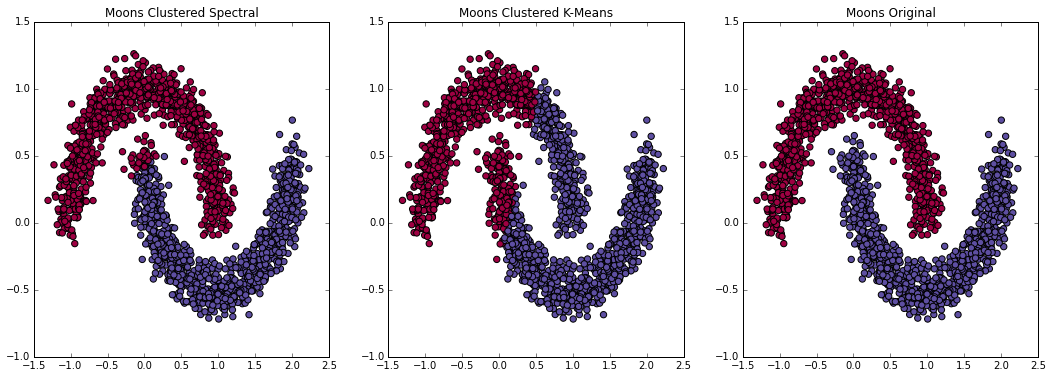

In [50]:
from sklearn.cluster import SpectralClustering
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
X_moon, y_moon = datasets.make_moons(2000, noise=0.1)

spectral = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors", n_neighbors=15)
spectral.fit(X_moon)
labels_spectral = spectral.labels_

centers_moon = kmeans(X_moon, k=2)
labels_kmeans = [find_closest_centroid(p, centers_moon) for p in X_moon]

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(X_moon[:,0], X_moon[:,1], s=40, c=labels_spectral, cmap=plt.cm.Spectral)
ax.set_title('Moons Clustered Spectral')
ax = fig.add_subplot(1, 3, 2)
ax.scatter(X_moon[:,0], X_moon[:,1], s=40, c=labels_kmeans, cmap=plt.cm.Spectral)
ax.set_title('Moons Clustered K-Means')
ax = fig.add_subplot(1, 3, 3)
ax.scatter(X_moon[:,0], X_moon[:,1], s=40, c=y_moon, cmap=plt.cm.Spectral)
ax.set_title('Moons Original')

plt.show()

<div class="alert alert-warning">

Looking at the moon example above, we can clearly see that Spectral Clustering based on nearest neighbours assignment outperforms K-means when it comes to density based clustering. From this we learn that we should always choose a suitable clustering algorithm for the data we are looking at.

</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [12]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase !!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [13]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = vector[:1]+vector[4:]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

# number of connections
n = data.count()

In [12]:
print(n)
data.take(1)

4898431


[array([  0.00000000e+00,   2.15000000e+02,   4.50760000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00])]

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

## Running mllib-PCA on the whole dataset

In [14]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [5]:
from pyspark.mllib.feature import PCA as PCAmllib
from pyspark.mllib.linalg import Vectors

data_dense = data.map(Vectors.dense)

model = PCAmllib(2).fit(data_dense)
transformed = model.transform(data_dense)

In [6]:
features_2d = np.array(transformed.map(lambda x: np.array([x[0], x[1]])).take(10000))

In [7]:
cluster_labels = clusters.predict(data_dense).take(10000)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


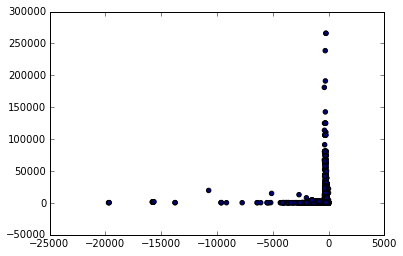

In [8]:
plt.scatter(features_2d[:,0], features_2d[:,1], c=cluster_labels[:])
plt.show()

## Running sklearn PCA on a sample of the dataset

Running sklearn PCA has the advantage that we can compute the percentage of explained variation of the original dataset in the transformed one.

In [9]:
# takeSample(withReplacement, num_samples, seed)
samples = data_dense.takeSample(False, 10000, 123)

In [10]:
samples_rdd = sc.parallelize(samples).map(Vectors.dense)

In [11]:
sample_labels = clusters.predict(samples_rdd).collect()

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


[ 0.59863909  0.39185532]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


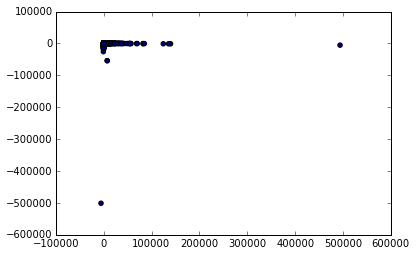

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(np.array(samples))

print(pca.explained_variance_ratio_)

plt.scatter(features_2d[:,0], features_2d[:,1], c=sample_labels)
plt.show()

<div class="alert alert-warning">
Reducing the dimensionality of the data to 2 dimensions, we explain around 99% of the sampled data's variance. This means that 99% of the variation takes place along the 2 major principal components. In the plot, we see this behaviour. The data mainly lies on two vertical lines (for the whole as well as for the sampled dataset). K-Means clustering does not seem to produce any sensible results yet (all data is assigned to the same cluster). We should better understand the features and normalize them to improve the k-Means results. Moreover, PCA might be problematic because some features have a different scaling from others and might therefore impact the axis of variation much more.
</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [15]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return(np.sum(np.subtract(point,closest_center)**2))

WSSSE = data.map(lambda point: error(clusters,point)).reduce(add)
WSSSE_MLLib = clusters.computeCost(data)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print("Within Set Sum of Squared Error with the implemented MLLib 'computeCost' function = " + str(WSSSE_MLLib))

Within Set Sum of Squared Error = 6.37937321457e+18
Within Set Sum of Squared Error with the implemented MLLib 'computeCost' function = 6.379373214570355e+18


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result ?

</div>

In [16]:
clusterLabelCount = clusters.predict(data).countByValue().items()

for item in clusterLabelCount:
    print(item)

(0, 2925804)
(1, 1972627)


<div class="alert alert-warning">

The distribution of assigned clusters among the datapoints is very uneven. This may be due to the random initialisation method that was chosen above which might not be working well with our dataset. Moreover, our features are not normalized yet, which may cause difficulties when applying k-means.

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$ ? Why ?

</div>

<div class="alert alert-warning">
From here on we will switch to k-means|| which is a faster implementation of k-means++ to increase computational performance.
</div>

In [17]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, initializationMode="k-means||")
    # calculate mean square error
    return data.map(lambda point: error(clusters,point)).reduce(add)

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


4.66345856702e+18
9.33882779455e+17
6.13418102887e+17
1.38625737923e+17
5.42387618588e+16
6.89541311046e+16
2.35983747081e+16
1.19875109689e+16
6.65284570976e+15
6.68435765681e+15
2.87250457768e+15
1.94440589092e+15
1.94440589091e+15
1.63075937987e+15
3.88077285889e+14
3.5064461978e+14
2.72879528873e+15
7.84076113056e+14
3.71413406171e+14
2.38209462757e+14
6.37441272864e+14
2.72595791318e+14
3.19293789365e+14
7.71328119728e+14
2.18042027047e+14
1.5606866018e+14
3.60048291344e+14
1.59891237697e+15
1.4342612502e+15


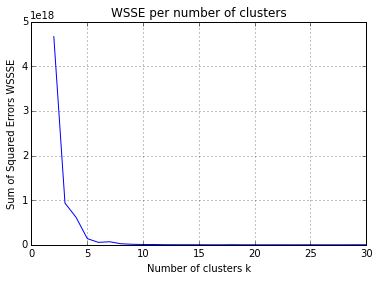

In [92]:
ks = range(2,31)
scores = [clusteringScore(data, k) for k in ks]
for score in scores:
    print(score)
    
# plot results
plt.plot(ks, scores)

plt.xlabel('Number of clusters k')
plt.ylabel('Sum of Squared Errors WSSSE')
plt.title('WSSE per number of clusters')
plt.grid(True)

plt.show()

<div class='alert alert-warning'>

<p>Looking only at the WSSSE values, we feel tempted to choose a high value of k.</p>

<p>However, let us consider the following scenario:</p>
<p>We set k to be the number of datapoints in our dataset. This way we can assign each datapoint to an own centroid and obtain an WSSSE value of 0 (there is no distortion in our dataset w.r.t. the clusters anymore). However, the clustering would be completely meaningless. A way to avoid picking a too extreme value of k is to penalize k in the scoring function.</p>
<p>This can be done by employing the Minimum Description Length metric which is a concept in information theory (https://en.wikipedia.org/wiki/Minimum_description_length).</p>
<p>The minimum description length allows us to mathematically capture the idea that we only wish to consider increasing the complexity of our models if that buys us a corresponding increase in descriptive power on our data.</p>
<p>A paper addressing the above mentioned issue: http://extras.springer.com/2001/978-1-4757-7516-7/tasks/task21/resul/publis/robust-methods/bls99.pdf</p>

<p>Intuitively, we would go for a value of k=10 when looking at the graph above. 10 is far less than the number of datapoints (around 5 million) and it gives us a low WSSSE value (the value converges to 0 for large k).</p>

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [14]:
from operator import add

In [15]:
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(add)
    print(sums)

    # calculate means
    means = sums / n

    # calculate the sum square of each feature (minus the mean?!)
    sumSquares = data.map(lambda x : x**2).reduce(add)
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = np.sqrt(sumSquares/n-np.power(means,2))
    
    # case stdev=0
    fake_stdevs = [stdev if stdev > 0.001 else 1 for stdev in stdevs]
    print(fake_stdevs)

    def normalize(point):
        return ((point - means) / fake_stdevs)

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))

[  2.36802060e+08   8.98676524e+09   5.35703589e+09   2.80000000e+01
   3.17800000e+03   3.90000000e+01   6.09250000e+04   1.57000000e+02
   7.03067000e+05   3.96200000e+04   3.34000000e+02   1.80000000e+02
   6.33610000e+04   5.82300000e+03   3.64000000e+02   5.00200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   1.64084428e+09
   1.44634545e+09   8.71775140e+05   8.72101730e+05   2.82468470e+05
   2.82786920e+05   3.86919313e+06   1.03746840e+05   1.38433600e+05
   1.14124176e+09   9.26852923e+08   3.69201228e+06   1.50436230e+05
   2.96380553e+06   3.16639800e+04   8.72367200e+05   8.71361620e+05
   2.83755350e+05   2.82440660e+05]
[  2.57433563e+12   4.34145810e+18   2.03795314e+18   2.80000000e+01
   8.99800000e+03   2.55000000e+02   1.07812100e+06   2.61000000e+02
   7.03067000e+05   7.28519560e+07   3.34000000e+02   3.20000000e+02
   7.59678130e+07   7.55510000e+04   3.74000000e+02   6.18200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   7.69775149e+1

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


5449762.38561
5002845.52408
4023063.77259
3375464.97987
3210149.19162
2749942.14917


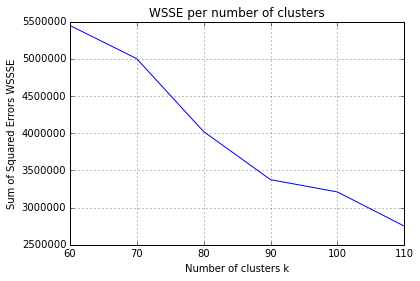

In [94]:
ks = [60, 70, 80, 90, 100, 110]

scores = [clusteringScore(normalizedData, k) for k in ks]
for score in scores:
    print(score)

plt.plot(ks, scores)

plt.xlabel('Number of clusters k')
plt.ylabel('Sum of Squared Errors WSSSE')
plt.title('WSSE per number of clusters')
plt.grid(True)

plt.show()

<div class='alert alert-warning'>

Here again the WSSSE errors decrease with increasing k. We obtain the lowest WSSSE value for k=110 which is still much lower than the number of datapoints. Therefore, we would select this value as the optimal one.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

In [89]:
clusters_raw = KMeans.train(data, 110, maxIterations=10, initializationMode="k-means||")

In [90]:
clusters_norm = KMeans.train(normalizedData, 110, maxIterations=10, initializationMode="k-means||")

## DONT RUN THE LABEL COUNTS AGAIN (VERY SLOW)

In [91]:
clusterLabelCount_raw = clusters_raw.predict(data).countByValue().items()
clusterLabelCount_norm = clusters_norm.predict(normalizedData).countByValue().items()

print('Raw label counts', clusterLabelCount_raw)
print('Normalized label counts', clusterLabelCount_norm)

Raw label counts dict_items([(0, 4862338), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 33), (14, 19), (15, 588), (16, 1), (17, 23), (18, 1), (19, 20), (20, 7), (21, 49), (22, 1), (23, 1), (24, 1), (25, 3), (26, 1), (27, 6), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 24), (34, 1), (35, 25), (36, 31), (37, 1), (38, 1), (39, 34735), (40, 2), (41, 83), (42, 1), (43, 1), (44, 1), (45, 2), (47, 4), (49, 6), (50, 3), (51, 1), (52, 1), (53, 1), (54, 11), (55, 2), (56, 2), (57, 8), (58, 9), (59, 7), (60, 3), (61, 21), (62, 1), (63, 1), (64, 3), (65, 30), (66, 142), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 23), (76, 1), (77, 95), (78, 22), (79, 4), (80, 1)])
Normalized label counts dict_items([(0, 235499), (1, 2804147), (2, 100574), (3, 2766), (4, 1), (5, 16), (6, 15172), (7, 25), (8, 8453), (9, 5495), (10, 39123), (11, 50212), (12, 100), (13, 240), (14, 1), (15, 4232), (16, 4), (17, 28), (18, 

In [92]:
from pyspark.mllib.feature import PCA as PCAmllib
from pyspark.mllib.linalg import Vectors

data_raw = data.map(Vectors.dense)
data_normal = data.map(Vectors.dense)

In [100]:
samples_raw = data.takeSample(False, 10000, 123123)
samples_norm = normalizedData.takeSample(False, 10000, 123123)
samples_raw_rdd = sc.parallelize(samples_raw)
samples_norm_rdd = sc.parallelize(samples_norm)

In [95]:
model_raw = PCAmllib(2).fit(data_raw)
model_norm = PCAmllib(2).fit(data_norm)

In [107]:
cluster_labels_raw = clusters_raw.predict(samples_raw_rdd).collect()
cluster_labels_norm = clusters_norm.predict(samples_norm_rdd).collect()

In [109]:
transformed_raw = model_raw.transform(samples_raw_rdd.map(Vectors.dense))
transformed_norm = model_norm.transform(samples_norm_rdd.map(Vectors.dense))
transformed_raw = np.array(transformed_raw.map(lambda x: np.array([x[0], x[1]])).collect())
transformed_norm = np.array(transformed_norm.map(lambda x: np.array([x[0], x[1]])).collect())

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


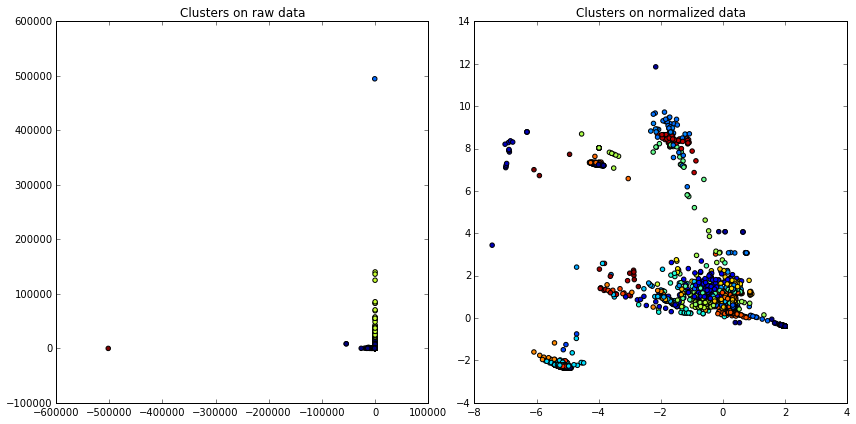

In [123]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.scatter(transformed_raw[:,0], transformed_raw[:,1], c=cluster_labels_raw[:])
ax1.set_title('Clusters on raw data')
ax2.scatter(transformed_norm[:,0], transformed_norm[:,1], c=cluster_labels_norm[:])
ax2.set_title('Clusters on normalized data')

plt.tight_layout()
plt.show()

<div class="alert alert-warning">

The normalization was indeed very useful. The clustering as well as the PCA now work much better. Looking at the label assignments of the dataset, we see a much better cluster distribution. Moreover, the data now varies equally in the different dimensions. Therefore, the PCA does not simply choose the axis of nominally largest variation anymore but takes the scaling of the features into account. The result is a scatterplot that is much better spread.

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorial feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping mapping **one** categorial feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [16]:
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
completeData = labelsAndData.values().cache()

In [17]:
###@!SOLUTION@!####
normalizedCompleteData = normalizeData(completeData).cache()

[  2.36802060e+08   8.98676524e+09   5.35703589e+09   2.80000000e+01
   3.17800000e+03   3.90000000e+01   6.09250000e+04   1.57000000e+02
   7.03067000e+05   3.96200000e+04   3.34000000e+02   1.80000000e+02
   6.33610000e+04   5.82300000e+03   3.64000000e+02   5.00200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   1.64084428e+09
   1.44634545e+09   8.71775140e+05   8.72101730e+05   2.82468470e+05
   2.82786920e+05   3.86919313e+06   1.03746840e+05   1.38433600e+05
   1.14124176e+09   9.26852923e+08   3.69201228e+06   1.50436230e+05
   2.96380553e+06   3.16639800e+04   8.72367200e+05   8.71361620e+05
   2.83755350e+05   2.82440660e+05]
[  2.57433563e+12   4.34145810e+18   2.03795314e+18   2.80000000e+01
   8.99800000e+03   2.55000000e+02   1.07812100e+06   2.61000000e+02
   7.03067000e+05   7.28519560e+07   3.34000000e+02   3.20000000e+02
   7.59678130e+07   7.55510000e+04   3.74000000e+02   6.18200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   7.69775149e+1

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


3980766.04465
3956229.61186
3181589.08916
2847784.52022
2571723.32519
2302510.74288
2318650.67514
1949282.46107
1954052.35355


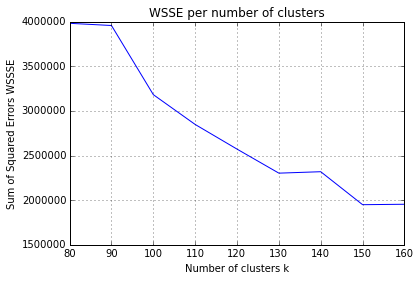

In [129]:
ks = [80,90,100,110,120,130,140,150,160]

scores = [clusteringScore(normalizedCompleteData, k) for k in ks]
for score in scores:
    print(score)

plt.plot(ks, scores)

plt.xlabel('Number of clusters k')
plt.ylabel('Sum of Squared Errors WSSSE')
plt.title('WSSE per number of clusters')
plt.grid(True)

plt.show()

<div class="alert alert-warning">


Including the categorical feature, we obtain k=150 as an optimal value among the tested ones.


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [18]:
clusters = KMeans.train(normalizedCompleteData, 150, maxIterations=10, runs=10, initializationMode="k-means||")

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [19]:
def distances(x):
    centroid_idx = clusters.predict(x)
    centroid = clusters.clusterCenters[centroid_idx]
    return (centroid_idx,[(euclidean_distance(x,centroid),x)])

normalizedCompleteData_clustersdistances = normalizedCompleteData.map(distances).reduceByKey(add)

In [21]:
threshold = 100

def takeOutliers(x):
    if type(x)==tuple:
        points = sorted(x[1],key=lambda x: x[0])
        outliers = points[np.min([len(points),threshold]):]
        return(x[0],len(outliers),outliers)
    else:
        return(x,0,[])

outliersRDD = normalizedCompleteData_clustersdistances.map(takeOutliers)


In [20]:
numberOutliersCluster = outliersRDD.map(lambda x: x[:2]).collectAsMap()

In [22]:
print("Outliers per cluster : " + str(numberOutliersCluster))
print("Total number of outliers : " + str(np.sum(list(numberOutliersCluster.values()))))
print("Average distance of each threshold to its center : " + str(np.mean(outliersRDD.map(lambda x: x[2][0][0] if len(x[2])>0 else 0).collect())))

Outliers per cluster : {0: 178484, 1: 162524, 2: 103960, 3: 0, 4: 97378, 5: 0, 6: 0, 7: 13736, 8: 1539, 9: 5103, 10: 4283, 11: 462, 12: 0, 13: 2627867, 14: 870, 15: 3226, 16: 45, 17: 9279, 18: 0, 19: 7933, 20: 11979, 21: 249, 22: 0, 23: 0, 24: 45681, 25: 12204, 26: 11798, 27: 8447, 28: 5722, 29: 0, 30: 1251, 31: 840, 32: 15975, 33: 0, 34: 0, 35: 68171, 36: 0, 37: 0, 38: 3363, 39: 8431, 40: 0, 41: 1433, 42: 0, 43: 216695, 44: 16, 45: 2457, 46: 6816, 47: 2533, 48: 1294, 49: 16595, 50: 0, 51: 259, 52: 0, 53: 5121, 54: 0, 55: 4660, 56: 0, 57: 0, 58: 5499, 59: 26709, 60: 3875, 61: 18320, 62: 16505, 63: 0, 64: 0, 65: 108, 66: 0, 67: 1384, 68: 11489, 69: 540, 70: 482043, 71: 0, 72: 753, 73: 0, 74: 0, 75: 1931, 76: 4601, 77: 81, 78: 946, 79: 0, 80: 4224, 81: 1087, 82: 157469, 83: 0, 84: 0, 85: 3662, 86: 1132, 87: 0, 88: 417, 89: 0, 90: 1962, 91: 590, 92: 168, 93: 1116, 94: 0, 95: 0, 96: 0, 97: 0, 98: 2427, 99: 0, 100: 0, 101: 0, 102: 11011, 103: 0, 104: 8586, 105: 17568, 106: 0, 107: 376, 108:

In [24]:
thresholds = [100, 1000, 10000, 100000, 1000000]

totalOutliers=[]
averageDistanceThres=[]
for threshold in thresholds:
    outliersRDD = normalizedCompleteData_clustersdistances.map(takeOutliers)
    numberOutliersCluster = outliersRDD.map(lambda x: x[:2]).collectAsMap()
    totalOutliers+=[np.sum(list(numberOutliersCluster.values()))]
    averageDistanceThres+=[np.mean(outliersRDD.map(lambda x: x[2][0][0] if len(x[2])>0 else 0).collect())]
    

KeyboardInterrupt: 

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.plot(thresholds, totalOutliers, c='r')
ax1.set_title('Total number of outliers per threshold')
ax2.scatter(thresholds, averageDistanceThres, c='b')
ax2.set_title('Average distance of each threshold to its center per threshold')

plt.tight_layout()
plt.show()

In [1]:
def takeOutliers(x):
    if type(x)==tuple:
        points = sorted(x[1],key=lambda x: x[0])
        q = len(points)/4
        q1 = point[int(q)][0]
        q3 = point[int(3*q)][0]
        iqr = q3-q1
        threshold = q3+1.5*iqr
        pos=len(points)
        for i in range(len(points)):
            if points[i][0]>=threshold:
                pos=i
                break
        outliers = points[pos:]
        return(x[0],len(outliers),outliers)
    else:
        return(x,0,[])

outliersRDD = normalizedCompleteData_clustersdistances.map(takeOutliers)
numberOutliersCluster = outliersRDD.map(lambda x: x[:2]).collectAsMap()
print("Outliers per cluster : " + str(numberOutliersCluster))
print("Total number of outliers : " + str(np.sum(list(numberOutliersCluster.values()))))
print("Average distance of each threshold to its center : " + str(np.mean(outliersRDD.map(lambda x: x[2][0][0] if len(x[2])>0 else 0).collect())))

NameError: name 'normalizedCompleteData_clustersdistances' is not defined

<div class="alert alert-warning">


We implemented the threshold method to get outliers in our dataset and detect anomalies. Our approach consists of taking each cluster individually and determine its outliers. As suggested we first took all the points of a cluster that are after a certain threshold index in the sorted distances to the centroids. For a threshold of 100 we clearly notice that we consider too many points to be outliers, resulting in an average distance of each threshold to its corresponding center that is too low.

As a second approach we determined the outliers by using the common paradigm of detecting datapoints that lie too far outside the 3rd quartile of the distances within the cluster (c.f. http://www.purplemath.com/modules/boxwhisk3.htm).

This is more reasonable since it determines a different outlier threshold for each cluster looking at the cluster's distribution of distances.


</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

In [49]:
from pyspark.mllib.linalg import Vectors

clusterAssignments = sc.parallelize(normalizedCompleteData.takeSample(False, 100)).map(Vectors.dense).map(lambda x: (clusters.predict(x),x)) \
                    .groupByKey().mapValues(list).cache()
    
print(clusterAssignments.take(2))

[(24, [DenseVector([-0.0668, -0.0014, -0.0017, -0.0024, -0.0151, -0.0011, -0.0265, -0.0044, -0.4094, -0.0021, -0.0083, -0.0045, -0.0033, -0.0096, -0.0085, -0.0288, 0.0, -0.0, -0.0289, 0.486, 0.5802, -0.466, -0.4658, -0.2483, -0.2481, 0.5397, -0.2561, -0.2011, 0.3439, 0.6211, 0.599, -0.2829, 0.8211, -0.1567, -0.4664, -0.4655, -0.2508, -0.2496])]), (12, [DenseVector([-0.0668, -0.0009, -0.0017, -0.0024, -0.0151, -0.0011, -0.0265, -0.0044, -0.4094, -0.0021, -0.0083, -0.0045, -0.0033, -0.0096, -0.0085, -0.0288, 0.0, -0.0, -0.0289, 0.8256, 0.8729, -0.466, -0.4658, -0.2483, -0.2481, 0.5397, -0.2561, -0.2011, 0.3439, 0.6211, 0.599, -0.2829, 0.8211, -0.1567, -0.4664, -0.4655, -0.2508, -0.2496]), DenseVector([-0.0668, -0.0009, -0.0017, -0.0024, -0.0151, -0.0011, -0.0265, -0.0044, -0.4094, -0.0021, -0.0083, -0.0045, -0.0033, -0.0096, -0.0085, -0.0288, 0.0, -0.0, -0.0289, 0.8256, 0.8729, -0.466, -0.4658, -0.2483, -0.2481, 0.5397, -0.2561, -0.2011, 0.3439, 0.6211, 0.599, -0.2829, 0.8211, -0.1567, -

In [ ]:
# Our silhouette implementation

def silhouette(row):
    centroid_idx = int(row[0])
    if type(row[1])==list:
        points = row[1]
    else:
        points = [row[1]]
    
    centroid_idxs = list(range(centroid_idx)) + list(range(centroid_idx+1,150))
    ss=[]
    for point in points:
        bs=[]
        for idx in centroid_idxs:
            other_points = clusterAssignments.filter(lambda x: x[0]==idx).collect()[1]
            bs += [np.mean([euclidean_distance(point,other) for other in other_points])]
        b = np.min(bs)
        a = np.mean([euclidean_distance(point,other) for other in points])
        s=0
        if a<b:
            s = 1-a/b
        elif b>a:
            s = a/b-1
        ss+=[s]
    return np.mean(ss)

s = normalizedCompleteData.map(silhouette).collect()
print(s)


<div class="alert alert-warning">


Above is our manual implementation of the silhouette scoring metric. But it wasn't succesful because of an implicit attempt to broadcast an RDD. That's why we switch to the sklearn implementation below.


</div>

For n_clusters = 2 The average silhouette_score is : 0.680258178002


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


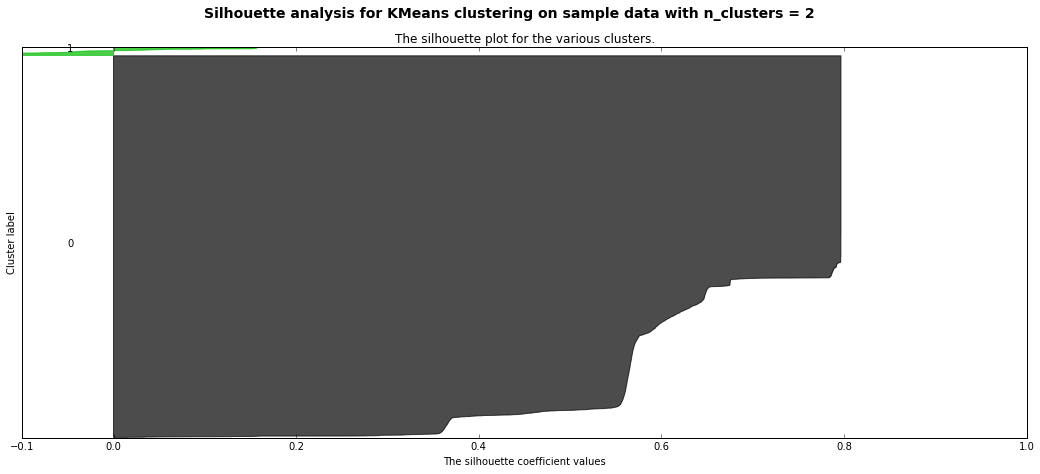

For n_clusters = 20 The average silhouette_score is : 0.856891597388


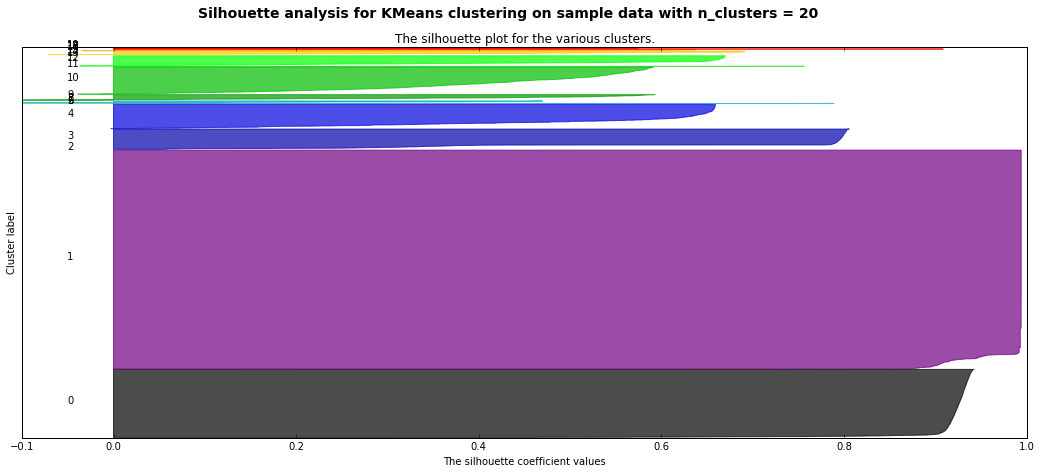

/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


For n_clusters = 70 The average silhouette_score is : 0.776150460022


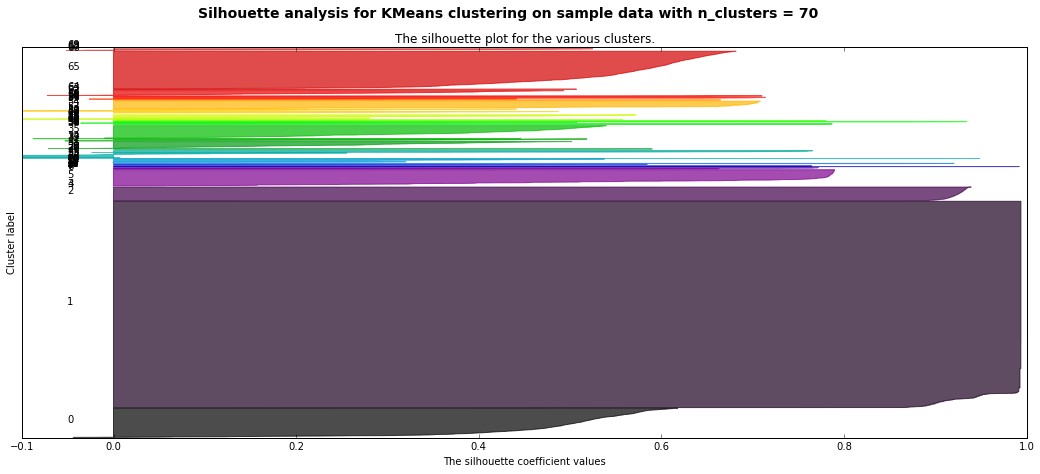

For n_clusters = 100 The average silhouette_score is : 0.850425401984


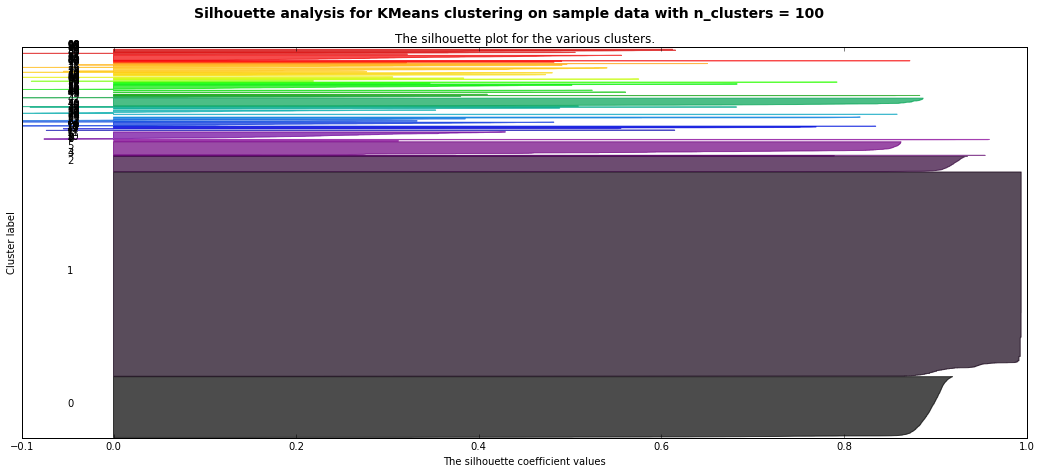

For n_clusters = 150 The average silhouette_score is : 0.731330985578


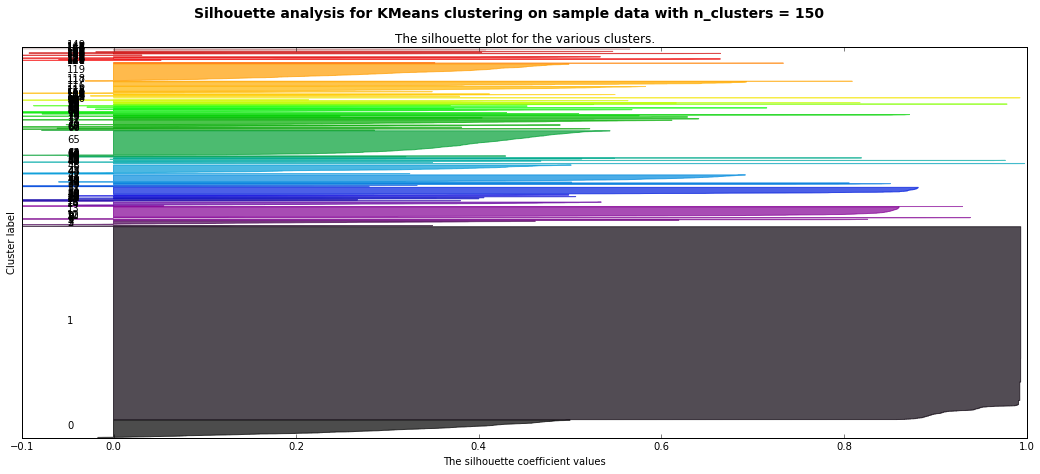

For n_clusters = 200 The average silhouette_score is : 0.710637911385


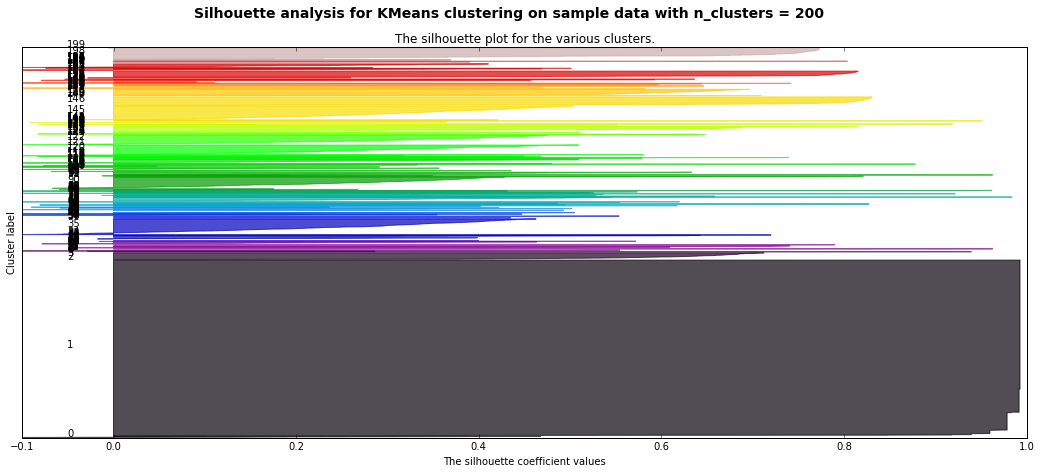

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
from pyspark.mllib.linalg import Vectors

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [2, 20, 70, 100, 150, 200]

for n_clusters in range_n_clusters:
    clusterer = KMeans.train(normalizedCompleteData, n_clusters, maxIterations=10, initializationMode="k-means||")
    dataSample = normalizedCompleteData.takeSample(False, 10000)
    samples_rdd = sc.parallelize(dataSample).map(Vectors.dense)
    samplesLabels = np.array(clusterer.predict(samples_rdd).collect())
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(np.array(dataSample), samplesLabels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataSample) + (n_clusters + 1) * 10])
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dataSample, samplesLabels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[samplesLabels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-warning">


Looking at the average silhouette values for different values of k, we find that k=20 and k=100 perform the best.
A high silhouette value means that we have a good coherence within clusters and a low coupling between clusters. However, we should also take the distribution among cluster labels into account. In this context, we consider k=20 to be better balanced.
The results are quite different from the WSSSE scores where we considered higher values of k to be better. This is due to the fact that we only investigate on the coherence of clusters when computing WSSSE. In the end we would rather choose k based on silhouette values because it is a more sophisticated evaluation metric (even though we cannot run it on the entire dataset for computational reasons).


</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [27]:
# MAX_ITERATIONS = 10000
MAX_ITERATIONS = 10

import time

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations >= MAX_ITERATIONS:
        return(True)
    # check if the centroids don't move (or very slightly)
    stop = [euclidean_distance(centroids[i], old_centroids[i])<=threshold for i in range(len(centroids))]
    return(all(stop))

t0 = int(time.time())
K = 150
# withReplacement, samples, seed
centroids = normalizedCompleteData.takeSample(False, K, 1)
converged = False

while not converged:
    # ASSIGNMENT STEP: find the closest centroid for each datapoint
    centroid_dists = normalizedCompleteData.map(lambda p: (find_closest_centroid(p, centroids), (p, 1)))
    # collect statistics for each cluster: (cluster_ind, (total_distance, number_assigned_points))
    cluster_stats = centroid_dists.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    # UPDATE STEP: update the centroids (total distance divided by number of points in resp. cluster)
    new_centroids = cluster_stats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()
    # convergence criterion
    centroid_coords = [point[1] for point in new_centroids]
    converged = check_converge(centroid_coords, centroids, MAX_ITERATIONS)
    # tempDist = sum(np.sum((centroids[iK] - p) ** 2) for (iK, p) in newPoints)
    for (idx, coords) in new_centroids:  
        centroids[idx] = coords
t1 = int(time.time())
print("Elapsed time to run || K-means : " + str(t1-t0))

Elapsed time to run || K-means : 424


In [28]:
t0 = int(time.time())
clusters = KMeans.train(normalizedCompleteData, 150, maxIterations=10, initializationMode="random")
t1 = int(time.time())
print("Elapsed time to run MLLib K-means : " + str(t1-t0))

Elapsed time to run MLLib K-means : 20


In [29]:
def error_2(centroids, point):
    closest_center = centroids[find_closest_centroid(point, centroids)]
    return(np.sum(np.subtract(point,closest_center)**2))

WSSSE = normalizedCompleteData.map(lambda point: error_2(centroids,point)).reduce(add)
print("WSSE error for || K-means : " + str(WSSSE))
print("WSSE error for MLLib K-means : " + str(clusters.computeCost(normalizedCompleteData)))

WSSE error for || K-means : 82099674.465
WSSE error for MLLib K-means : 46059709.85539055


<div class="alert alert-warning">


Our parallel implementation of k-Means runs about 20 times slower than the MLLIB implementation. It also performs worse in terms of WSSSE scoring (about twice the error).
We assume that this is due to further optimization that has been carried out in the mllib implementation. This kind of optimization is beyond the scope of our current work. However, our implementation is still a lot more efficient than a sequential implementation of k-Means.

</div>